In [89]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
total = 22606

# FUNCTIONS
#### String to date time:
Transform files to desirable format
#### Join times:
Combine the overlaped intervals from the two different sources
#### Total alert time:
Computes the total amount of minutes pertaining to the time intervals
#### Roc values:
Returns list with ROC parameteres + Youden

#### Read files
* Intervals1: data from the morphological approach
* Intervals2: data from the derivative approach

In [307]:
def strings_to_datetime(df):
    df['hora inici'] = (pd.to_datetime(df['dia'] + ' ' + df['hora inici']))
    df['hora final'] = (pd.to_datetime(df['dia'] + ' ' + df['hora final']))
    df['dia'] = (pd.to_datetime(df['dia'])).dt.date

    return df

def join_times(x):
    startdf = pd.DataFrame({'time':x['hora inici'], 'what':1})
    enddf = pd.DataFrame({'time':x['hora final'], 'what':-1})
    mergdf = pd.concat([startdf, enddf]).sort_values(['time', 'what'], ascending=[True, False])
    mergdf['running'] = mergdf['what'].cumsum()
    mergdf['newwin'] = mergdf['running'].eq(1) & mergdf['what'].eq(1)
    mergdf['group'] = mergdf['newwin'].cumsum()
    x['group'] = mergdf['group'].loc[mergdf['what'].eq(1)]
    grouped_df = x.groupby('group')
    combined = pd.DataFrame()
    combined = grouped_df.max()
    combined['hora inici'] = grouped_df['hora inici'].min()
    combined['metode'] = grouped_df['metode'].mean()
    return combined

def total_alert_time(x):
    total_time = ((x['hora final'] - x['hora inici'])/np.timedelta64(1,'m')).sum()
    return total_time

def roc_values_min(x):
    one_a_day = x[x['resultat'] == 'VERDADERO']
    one_a_day['date'] = one_a_day['hora inici'].dt.date
    one_a_day = one_a_day[(one_a_day['date'] != date(2017, 9, 6))
                          & (one_a_day['date'] != date(2013, 10, 28))
                          & (one_a_day['date'] != date(2013, 10, 25))]
    extras = one_a_day.duplicated('date').sum()
    print(extras)
    true_x = x[x['resultat'] == 'VERDADERO']
    false_x = x[x['resultat'] == 'FALSO']
    true_positives = len(true_x) - extras #events
    false_positives_min = total_alert_time(false_x) #minutes
    false_positives_event = len(false_x) #events
    true_negatives = 22606 - total_alert_time(x) #minutes
    false_negatives = 33 - true_positives #events
    TPR = true_positives/(true_positives + false_negatives)
    FPR = false_positives_min/(false_positives_min + true_negatives)
    TNR = true_negatives/(true_negatives + false_positives_min)
    youden = TPR + TNR - 1
    
    return [true_positives, false_positives_event, false_positives_min, TPR, FPR, youden]

def roc_values_event_16(x):
    one_a_day = x[x['resultat'] == 'VERDADERO']
    one_a_day['date'] = one_a_day['hora inici'].dt.date
    one_a_day = one_a_day[(one_a_day['date'] != date(2017, 9, 6))
                          & (one_a_day['date'] != date(2013, 10, 28))
                          & (one_a_day['date'] != date(2013, 10, 25))]
    extras = one_a_day.duplicated('date').sum()
    true_x = x[x['resultat'] == 'VERDADERO']
    false_x = x[x['resultat'] == 'FALSO']
    true_positives = len(true_x) - extras #events
    false_positives = len(false_x)
    true_negatives = (22606 - total_alert_time(x))/16
    false_negatives = 33 - true_positives #events
    TPR = true_positives/(true_positives + false_negatives)
    FPR = false_positives/(false_positives + true_negatives)
    TNR = true_negatives/(true_negatives + false_positives)
    youden = TPR + TNR - 1
    
    return [true_positives, false_positives, true_negatives, TPR, FPR, youden]

def roc_values_event_mean(x):
    one_a_day = x[x['resultat'] == 'VERDADERO']
    one_a_day['date'] = one_a_day['hora inici'].dt.date
    one_a_day = one_a_day[(one_a_day['date'] != date(2017, 9, 6))
                          & (one_a_day['date'] != date(2013, 10, 28))
                          & (one_a_day['date'] != date(2013, 10, 25))]
    extras = one_a_day.duplicated('date').sum()
    true_x = x[x['resultat'] == 'VERDADERO']
    false_x = x[x['resultat'] == 'FALSO']
    true_positives = len(true_x) - extras #events
    false_positives = len(false_x)
    mean_duration = total_alert_time(x)/len(x)
    true_negatives = (22606 - total_alert_time(x))/mean_duration
    false_negatives = 33 - true_positives #events
    TPR = true_positives/(true_positives + false_negatives)
    FPR = false_positives/(false_positives + true_negatives)
    TNR = true_negatives/(true_negatives + false_positives)
    youden = TPR + TNR - 1
    
    return [true_positives, false_positives, true_negatives, TPR, FPR, youden]

    

#### Margin:
Give some minutes of margin to take two intervals as a longer one

In [233]:
def margin(x):
    x['diff'] = ((x['hora inici'] - x['hora final'].shift(1))/np.timedelta64(1, 'm')) > 3
    x['group 2'] = x['diff'].cumsum()
    grouped_df = x.groupby('group 2')
    x = pd.DataFrame()
    x = grouped_df.max()
    x['hora inici'] = grouped_df['hora inici'].min()
    x['metode'] = grouped_df['metode'].mean()
    grouped_df = x.groupby('group 2')
    final = pd.DataFrame()
    final = grouped_df.max()
    final['hora inici'] = grouped_df['hora inici'].min()
    final['metode'] = grouped_df['metode'].mean()
    return final

# Area for tests

In [267]:
file1 = 'intervals_collections/intervals_anna/intervals-0.99.csv'
Intervals1 = pd.read_csv(file1, index_col=0, delimiter=';')
Intervals1['metode'] = 1
strings_to_datetime(Intervals1)
file2 = 'intervals_collections/intervals_alba/alba-0.7.csv'
Intervals2 = pd.read_csv(file2, index_col=None, delimiter=';')
Intervals2['metode'] = 2
strings_to_datetime(Intervals2)

merged = pd.merge_ordered(Intervals1, Intervals2,
              on=['dia', 'hora inici', 'hora final', 'resultat', 'metode'])
combined = join_times(merged)
final = margin(combined)
display(final[final['resultat'] == 'VERDADERO'])

,dia,hora inici,hora final,resultat,metode,diff
group 2,,,,,,
4,2001-04-15,2001-04-15 13:40:30,2001-04-15 14:08:00,VERDADERO,1.5,True
6,2001-04-26,2001-04-26 13:01:30,2001-04-26 13:11:00,VERDADERO,1.5,True
7,2001-12-13,2001-12-13 14:20:30,2001-12-13 14:38:00,VERDADERO,1.5,True
8,2004-07-16,2004-07-16 13:50:00,2004-07-16 14:04:00,VERDADERO,2.0,True
11,2004-07-20,2004-07-20 12:24:00,2004-07-20 12:50:00,VERDADERO,2.0,True
17,2004-08-14,2004-08-14 13:38:00,2004-08-14 13:43:00,VERDADERO,2.0,True
18,2004-08-15,2004-08-15 12:35:00,2004-08-15 12:47:00,VERDADERO,2.0,True
19,2005-05-27,2005-05-27 12:25:00,2005-05-27 12:26:00,VERDADERO,2.0,True
20,2005-09-09,2005-09-09 09:53:00,2005-09-09 10:09:00,VERDADERO,2.0,True


# Combined Youden matrix + plots

In [312]:
youden_matrix = pd.DataFrame({})
TP_matrix = pd.DataFrame({})
FP_matrix = pd.DataFrame({})

for corr in np.arange(0.977, 0.994, 0.001):
    file1 = f'intervals_collections/intervals_anna/intervals-{corr}.csv'
    Intervals1 = pd.read_csv(file1, index_col=0, delimiter=';')
    Intervals1['metode'] = 1
    strings_to_datetime(Intervals1)

    for delta in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        file2 = f'intervals_collections/intervals_alba/alba-{delta}.csv'
        Intervals2 = pd.read_csv(file2, index_col=None, delimiter=';')
        Intervals2['metode'] = 2
        strings_to_datetime(Intervals2)
        
        merged = pd.merge_ordered(Intervals1, Intervals2,
              on=['dia', 'hora inici', 'hora final', 'resultat', 'metode'])
        combined = join_times(merged)
        combined['dia'] = combined['hora final'] - combined['hora inici']
        final = margin(combined)

        youden_matrix.loc[corr, delta] = roc_values_event_16(final)[5]
        TP_matrix.loc[corr, delta] = roc_values_event_16(final)[0]
        FP_matrix.loc[corr, delta] = roc_values_event_16(final)[1]
youden_matrix.to_excel('youden_events_16.xlsx')
#TP_matrix.to_excel('TP.xlsx')
#FP_matrix.to_excel('FP.xlsx')

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_a_day['date'] = one_a_day['hora inici'].dt.date
<ipython-input-307-aa40d4a2e937>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

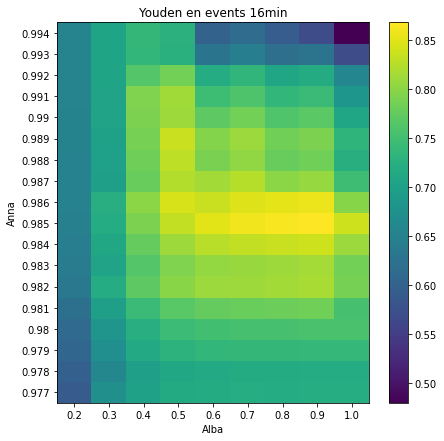

In [313]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.pcolor(youden_matrix, antialiased=False)
plt.yticks(np.arange(0.5, len(youden_matrix.index), 1), youden_matrix.index)
plt.xticks(np.arange(0.5, len(youden_matrix.columns), 1), youden_matrix.columns)
plt.title('Youden en events 16min')
plt.xlabel('Alba')
plt.ylabel('Anna')
plt.colorbar()
plt.show()

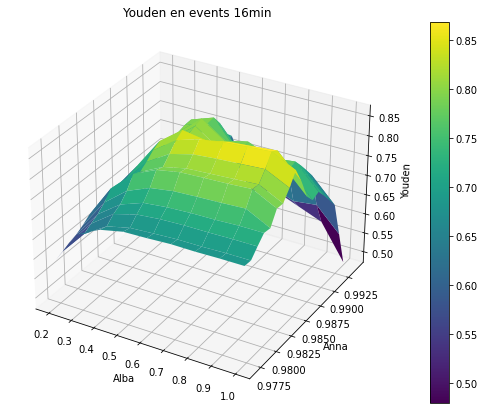

In [314]:
youden_array = youden_matrix.to_numpy()

d,y = np.meshgrid(np.arange(0.2, 1.1, 0.1),np.arange(0.977, 0.994, 0.001))
plt.rcParams['figure.figsize'] = [15, 7]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(d, y, youden_array, rstride=1, cmap=cm.viridis, cstride=1, linewidth=1, antialiased=True)
plt.title('Youden en events 16min')
ax.set_xlabel('Alba')
ax.set_ylabel('Anna')
ax.set_zlabel('Youden')
m = cm.ScalarMappable(cmap=cm.viridis)
m.set_array(youden_array)
plt.colorbar(m)

plt.show()